# Classification of Land Use with the Masterful CLI Trainer

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)][1]&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[![Download](images/download.png)][2][Download this Notebook][2]

[1]:https://colab.research.google.com/github/masterfulai/masterful-docs/blob/main/notebooks/guide_cli_classification_land_use.ipynb
[2]:https://docs.masterfulai.com/0.6.0/notebooks/guide_cli_classification_land_use.ipynb

In this guide, you will take a deeper look at Classification with the [Masterful CLI Trainer](../notebooks/tutorial_quickstart_cli.ipynb) to train a state of the art model. 

This guide will use a satellite imagery dataset from [UCMerced](http://weegee.vision.ucmerced.edu/datasets/landuse.html) to classify different plots of land according to their usage. 

## Define the Application

In this guide, your challenge is to build a computer vision model that can classify different plots of land according to their usage. In this instance, the images have already been extracted from larger satellite imagery and each image can be classified into a single category.

Since each image can be categorized into a single class, and there are more than one possible classes, the computer vision task for this problem is **multi-class classification**.


## TL;DR

Don't want to read the rest of this guide, and want to start training
immediately? The following command shows you how to start training
with Masterful, using a configuration file and dataset on S3.

```
masterful-train --config https://masterful-public.s3.us-west-1.amazonaws.com/datasets/ucmerced/training.yaml
```

## Prepare the Data

For this guide, you will use the [UCMerced](http://weegee.vision.ucmerced.edu/datasets/landuse.html) dataset, which is a land use classification dataset used for image classification. In this section, you will take the raw dataset and convert it into a format that Masterful can understand. Along the way, you will visualize a few examples of the data to see both the input to the model, as well as the predictions after training the model.

The [UCMerced](http://weegee.vision.ucmerced.edu/datasets/landuse.html) dataset contains 100 images for each of 21 different classes. Each image measures 256x256 pixels. The images were manually extracted from large images from the USGS National Map Urban Area Imagery collection for various urban areas around the country. The pixel resolution of this public domain imagery is 1 foot.

The CSV format for Image Classification can be found at [Masterful Image Classification](../markdown/guide_cli_data_directory_format.md#multi-class-classification). Each line contains the relative path to the image, and the 0-indexed integer of the groundtruth class. For example, the following are the first few lines from the [trainval.csv](https://masterful-public.s3.us-west-1.amazonaws.com/datasets/ucmerced/trainval.csv) file:  

```
images/golfcourse17.png, 9
images/intersection98.png, 11
images/agricultural59.png, 0
images/overpass28.png, 14
images/agricultural81.png, 0
images/freeway01.png, 8
images/river77.png, 16
.
.
.
```

The [label map](https://masterful-public.s3.us-west-1.amazonaws.com/datasets/ucmerced/label_map.csv) file helps convert the integer class indices into human readable forms. The [label map](https://masterful-public.s3.us-west-1.amazonaws.com/datasets/ucmerced/label_map.csv) for UCMerced looks like:  

```
0,agricultural
1,airplane
2,baseballdiamond
3,beach
4,buildings
5,chaparral
6,denseresidential
7,forest
8,freeway
9,golfcourse
10,harbor
11,intersection
12,mediumresidential
13,mobilehomepark
14,overpass
15,parkinglot
16,river
17,runway
18,sparseresidential
19,storagetanks
20,tenniscourt
```

Converting each dataset is typically a one-off operation that is different for every dataset you want to train with. For brevity, you can use the already converted dataset located at the public S3 bucket `s3://masterful-public/datasets/ucmerced/`. In this bucket, you will see the following files:

```
ucmerced\
  test.csv
  trainval.csv
  training.yaml
  label_map.csv
  images\
```

### Explore the Data

You should always visually inspect your dataset to get a sense of what the model will see, and to roughly verify that your dataset conversion routine worked properly and you are not training with corrupted or incorrect data.

In [2]:
# Install dependencies necessary to run the following
# code.
!pip install opencv-python-headless --quiet
!pip install masterful --quiet

# Import the packages used below.
import matplotlib.pyplot as plt
import os
import requests
import tarfile
import tempfile
import tensorflow as tf
import urllib.request

# Import and activate the Masterful package.
import masterful
masterful = masterful.activate()

# Helper function to display a progress when downloading
# a file using HTTP.
from masterful.utils.downloader import progress_bar_factory

# This is necessary for running inside of Colab/Jupyter,
# since the CLI trainer is run outside of the kernel
# (as a script command).
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

MASTERFUL: Your account has been successfully activated. Masterful v0.5.2 is loaded.


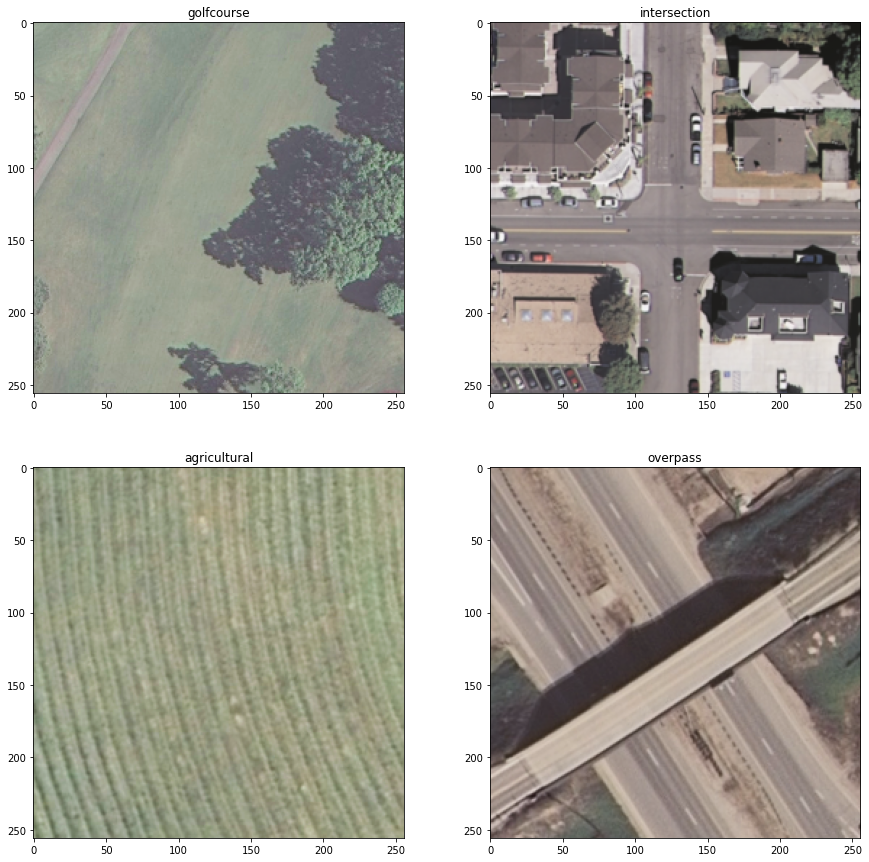

In [11]:
DATASET_ROOT = "https://masterful-public.s3.us-west-1.amazonaws.com/datasets/ucmerced/"
TRAINING_CSV_URL = os.path.join(DATASET_ROOT, "trainval.csv")

with tempfile.TemporaryDirectory() as temp_directory:
  training_csv_name = os.path.join(temp_directory, "trainval.csv") 
  _ =  urllib.request.urlretrieve(TRAINING_CSV_URL, training_csv_name)

  examples = []
  with open(training_csv_name) as training_csv:
    examples = training_csv.readlines()

image1_path, label1 = examples[0].split(',')
image2_path, label2 = examples[1].split(',')
image3_path, label3 = examples[2].split(',')
image4_path, label4 = examples[3].split(',')

label_map = {
  "0": "agricultural",
  "1": "airplane",
  "2": "baseballdiamond",
  "3": "beach",
  "4": "buildings",
  "5": "chaparral",
  "6": "denseresidential",
  "7": "forest",
  "8": "freeway",
  "9": "golfcourse",
  "10": "harbor",
  "11": "intersection",
  "12": "mediumresidential",
  "13": "mobilehomepark",
  "14": "overpass",
  "15": "parkinglot",
  "16": "river",
  "17": "runway",
  "18": "sparseresidential",
  "19": "storagetanks",
  "20": "tenniscourt",
}
image1 = tf.io.decode_image(urllib.request.urlopen(urllib.request.Request(os.path.join(DATASET_ROOT, image1_path))).read(), channels=3, dtype=tf.float32)
image2 = tf.io.decode_image(urllib.request.urlopen(urllib.request.Request(os.path.join(DATASET_ROOT, image2_path))).read(), channels=3,  dtype=tf.float32)
image3 = tf.io.decode_image(urllib.request.urlopen(urllib.request.Request(os.path.join(DATASET_ROOT, image3_path))).read(), channels=3,  dtype=tf.float32)
image4 = tf.io.decode_image(urllib.request.urlopen(urllib.request.Request(os.path.join(DATASET_ROOT, image4_path))).read(), channels=3,  dtype=tf.float32)

f, axarr = plt.subplots(2, 2, figsize=(15,15))
_ = axarr[0, 0].imshow(image1)
_ = axarr[0, 0].title.set_text(label_map[label1.strip()])
_ = axarr[0, 1].imshow(image2)
_ = axarr[0, 1].title.set_text(label_map[label2.strip()])
_ = axarr[1, 0].imshow(image3)
_ = axarr[1, 0].title.set_text(label_map[label3.strip()])
_ = axarr[1, 1].imshow(image4)
_ = axarr[1, 1].title.set_text(label_map[label4.strip()])


## Configure the CLI Trainer

The Masterful CLI Trainer is a command line tool that trains a production quality model with no code required. The Masterful CLI Trainer take a [YAML](../markdown/guide_cli_yaml_config.md) configuration file as input. The configuration file fully specifies everything necessary for training, including the dataset, model, export formats, and evaluation metrics.

### Choosing a Model

Masterful provides many different state of the art image classification models that you can choose from. In general, choosing a model can have different constraints than training the model (are you deploying on server or edge? Runtime or latency constraints? Memory constraints?). You generally want to choose a model that is large enough to fit your data, but not so large as to overfit the training data and "memorize" the results, which can lead to poor generalization performance.

The Masterful Image Classification Model Zoo supports the following model architectures.

|         Model Name        | Year |                                                                                                 Description                                                                                                |
|:-------------------------:|:----:|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------:|
|        `resnet50v1`       | 2015 | ResNet-50 architecture from the paper [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)                                                                                     |
|       `resnet101v1`       | 2015 | ResNet-101 architecture from the paper  [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)                                                                                   |
|       `resnet152v1`       | 2015 | ResNet-152 architecture from the paper  [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385)                                                                                   |
|        `resnet50v2`       | 2016 | ResNet-50 architecture from the paper [Identity Mappings in Deep Residual Networks](https://arxiv.org/abs/1603.05027)                                                                                      |
|       `resnet101v2`       | 2016 | ResNet-101 architecture from the paper  [Identity Mappings in Deep Residual Networks](https://arxiv.org/abs/1603.05027)                                                                                    |
|       `resnet152v2`       | 2016 | ResNet-152 architecture from the paper  [Identity Mappings in Deep Residual Networks](https://arxiv.org/abs/1603.05027)                                                                                    |
|    `efficientnetb0_v1`    | 2019 | `B0` architecture from the paper [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946)                                                              |
| `efficientnetb0_v1_small` | 2019 | `B0` architecture from the paper [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946). This architecture is tuned for small `(32x32)` input sizes. |
|    `efficientnetb1_v1`    | 2019 | `B1` architecture from the paper [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946)                                                              |
|    `efficientnetb2_v1`    | 2019 | `B2` architecture from the paper [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946)                                                              |
|    `efficientnetb3_v1`    | 2019 | `B3` architecture from the paper [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946)                                                              |
|    `efficientnetb4_v1`    | 2019 | `B4` architecture from the paper [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946)                                                              |
|    `efficientnetb5_v1`    | 2019 | `B5` architecture from the paper [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946)                                                              |
|    `efficientnetb6_v1`    | 2019 | `B6` architecture from the paper [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946)                                                              |
|    `efficientnetb7_v1`    | 2019 | `B7` architecture from the paper [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946)                                                              |
|    `mobilenetv3_small`    | 2019 | The `small` architecture (`alpha = 1.0`) from the paper [Searching for MobileNetV3](https://arxiv.org/abs/1905.02244)                                                                                      |
|    `mobilenetv3_large`    | 2019 | The `large` architecture (`alpha = 1.0`) from the paper [Searching for MobileNetV3](https://arxiv.org/abs/1905.02244)                                                                                      |
|          `vgg16`          | 2015 | The `VGG16` architecture from the paper [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)                                                              |
|          `vgg19`          | 2015 | The `VGG19` architecture from the paper [Very Deep Convolutional Networks for Large-Scale Image Recognition](https://arxiv.org/abs/1409.1556)                                                              |
|         `xception`        | 2017 | The `Xception v1` architecture from the paper [Xception: Deep Learning with Depthwise Separable Convolutions](https://arxiv.org/abs/1610.02357)                                                            |
|       `inception_v3`      | 2016 | The `Inception V3` architecture from the paper [Rethinking the Inception Architecture for Computer Vision](https://arxiv.org/abs/1512.00567)                                                               |

In the example below, you will select a [resnet50v1](https://arxiv.org/abs/1512.03385) model. This is a great model to start with, as it generalizes well across most domains.

### The Configuration File

The following section is a condensed YAML configuration file for training against this dataset with **NO** unlabeled data. It points to the dataset created above, and selects a `resnet50v1` model, which is a good model for small datasets and edge inference use cases. 

Note all of the model artifacts will be saved to the directory `~/model_output`, which you can configure in the `output` section below.

The original YAML file can be found [here](https://masterful-public.s3.us-west-1.amazonaws.com/datasets/ucmerced/training.yaml).

```yaml
dataset:
  root_path: https://masterful-public.s3.us-west-1.amazonaws.com/datasets/ucmerced
  splits: [trainval, test]
  label_map: label_map
  optimize: True
model:
  architecture: resnet50v1
  num_classes: 21
  input_shape: [256,256,3]
training:
  task: classification
  training_split: trainval
output:
  formats: [saved_model, onnx]
  path: ~/model_output
evaluation:
  split: test
```

## Train the Model

Training the model involves simply running the Masterful CLI Trainer (`masterful-train`) against the YAML file on S3.

Below, you will setup the CLI and configuration file to run in this notebook. However, if you want to train this model outside of the notebook, against the dataset on S3, you can run:

```
masterful-train --config https://masterful-public.s3.us-west-1.amazonaws.com/datasets/ucmerced/training.yaml
```

In [1]:
# Use the Masterful CLI to train the model without unlabeled data
!masterful-train --config https://masterful-public.s3.us-west-1.amazonaws.com/datasets/ucmerced/training.yaml

MASTERFUL: Your account has been successfully activated. Masterful v0.5.2 is loaded.
MASTERFUL [14:04:16]: Training with configuration 'https://masterful-public.s3.us-west-1.amazonaws.com/datasets/ucmerced/training.yaml':
----------  --------------------------------------------------------------------------------
dataset     root_path  https://masterful-public.s3.us-west-1.amazonaws.com/datasets/ucmerced
            splits     ['trainval', 'test']
            label_map  label_map
            optimize   True
model       architecture  resnet50v1
            num_classes   21
            input_shape   [256, 256, 3]
training    task            classification
            training_split  trainval
output      formats  ['saved_model', 'onnx']
            path     ~/model_output
evaluation  split  test
----------  --------------------------------------------------------------------------------
MASTERFUL [14:04:20]: Building model 'resnet50v1'...
MASTERFUL [14:04:22]: Using model resnet50v1 with:

MASTERFUL [14:05:27]: Training dataset learner finished at 14:05:27 in 1 seconds (1s), returned:
-------------------------  -----------------------------
num_classes                21
task                       Task.CLASSIFICATION
image_shape                (256, 256, 3)
image_range                ImageRange.IMAGENET_CAFFE_BGR
image_dtype                <dtype: 'float32'>
image_channels_last        True
label_dtype                <dtype: 'float32'>
label_shape                (21,)
label_structure            TensorStructure.SINGLE_TENSOR
label_sparse               False
label_bounding_box_format
-------------------------  -----------------------------
MASTERFUL [14:05:27]: Meta-learning test dataset parameters...
MASTERFUL [14:05:28]: Test dataset learner finished at 14:05:28 in 1 seconds (1s), returned:
-------------------------  -----------------------------
num_classes                21
task                       Task.CLASSIFICATION
image_shape                (256, 256, 3)
image_rang

MASTERFUL [15:38:19]: Training model with semi-supervised learning disabled.
MASTERFUL [15:38:20]: Performing basic dataset analysis.
MASTERFUL [15:38:26]: Masterful will use 189 labeled examples as a validation set since no validation data was provided.
MASTERFUL [15:38:26]: Training model with:
MASTERFUL [15:38:26]: 	1701 labeled examples.
MASTERFUL [15:38:26]: 	189 validation examples.
MASTERFUL [15:38:26]: 	0 synthetic examples.
MASTERFUL [15:38:26]: 	0 unlabeled examples.
MASTERFUL [15:38:27]: Training model with learned parameters margin-repeated-albacore in two phases.
MASTERFUL [15:38:27]: The first phase is supervised training with the learned parameters.
MASTERFUL [15:38:27]: The second phase is semi-supervised training to boost performance.
MASTERFUL [15:38:29]: Warming up model for supervised training.
MASTERFUL [15:38:34]: 	Warming up batch norm statistics (this could take a few minutes).
MASTERFUL [15:38:38]: 	Warming up training for 505 steps.
100%|██████████████████████

## Analyze the Results

At the end of training, Masterful will evaluate your model based on the test (sometimes called holdout) dataset you specified in the `evaluation` section of your configuration file. The evaluation results are different for each task, since every computer vision task has both general metrics (such as loss) as well as task-specific metrics (IoU for semantic segmentation for example). These results are printed to the console, as well as saved into a CSV file in the output directory specified in your configuration file.

### Image Classification Evaluation Metrics

For Image Classification, Masterful reports three main categories of metrics: Model Loss, Model Accuracy, and Confusion Matrix.

#### Model Loss

The first set of metrics Masterful reports is the overall loss of the model. The following is the loss result from the above training run (this might be different if you rerun the above cells):  

```
MASTERFUL [16:00:06]: Evaluating model on 210 examples from the 'test' dataset split:
Evaluating: 100%|████████████████████████████| 210/210 [00:00<00:00, 314.89it/s]
MASTERFUL [16:00:07]:   Loss: 0.1323
```

As you can see in the above output, the total loss of the model is `MASTERFUL [16:00:07]:   Loss: 0.1323`. This seems like a pretty good loss value. It is relatively low and close to zero, which is the goal of the optimizer in machine learning training. However, it's really difficult to understand intuitively what this means in terms of your models overall performance. Are these good values? Or bad ones? Let's dive into the rest of the metrics to answer these questions.

#### Model Accuracy

Next Masterful reports the categorical accuracy of the model. This is an overall measure of the quality of your model, and is a good quantitative measure of the performance of your model when your test dataset is well balanced.

```
MASTERFUL [16:00:07]:   Categorical Accuracy: 0.9714
```

In this instance, the model is 97% accurate, which is a really good value!


#### Confusion Matrix

The final set of metrics Masterful provides for Image Classification is the confusion matrix of predictions versus labels. The confusion matrix helps figure out where and how the model makes mistakes. Masterful also provides a summary of the confusion matrix in the form of Precision and Recall values.  

Below is the output for the confusion matrix from the training process:  

In [ ]:
MASTERFUL [16:00:09]:   Confusion Matrix:
MASTERFUL [16:00:09]:                      |      agricultural|          airplane|   baseballdiamond|             beach|         buildings|         chaparral|  denseresidential|            forest|           freeway|        golfcourse|            harbor|      intersection| mediumresidential|    mobilehomepark|          overpass|        parkinglot|             river|            runway| sparseresidential|      storagetanks|       tenniscourt|
MASTERFUL [16:00:09]:          agricultural|                12|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|
MASTERFUL [16:00:09]:              airplane|                 0|                11|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|
MASTERFUL [16:00:09]:       baseballdiamond|                 0|                 0|                 8|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|
MASTERFUL [16:00:09]:                 beach|                 0|                 0|                 0|                13|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|
MASTERFUL [16:00:09]:             buildings|                 0|                 0|                 0|                 0|                14|                 0|                 2|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 1|                 0|
MASTERFUL [16:00:09]:             chaparral|                 0|                 0|                 0|                 0|                 0|                10|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|
MASTERFUL [16:00:09]:      denseresidential|                 0|                 0|                 0|                 0|                 0|                 0|                10|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|
MASTERFUL [16:00:09]:                forest|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 9|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|
MASTERFUL [16:00:09]:               freeway|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                16|                 0|                 0|                 0|                 0|                 0|                 1|                 0|                 0|                 0|                 0|                 0|                 0|
MASTERFUL [16:00:09]:            golfcourse|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 6|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|
MASTERFUL [16:00:09]:                harbor|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                10|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|
MASTERFUL [16:00:09]:          intersection|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                15|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|
MASTERFUL [16:00:09]:     mediumresidential|                 0|                 0|                 0|                 0|                 0|                 0|                 1|                 0|                 0|                 0|                 0|                 0|                10|                 0|                 0|                 0|                 0|                 0|                 1|                 0|                 0|
MASTERFUL [16:00:09]:        mobilehomepark|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 9|                 0|                 0|                 0|                 0|                 0|                 0|                 0|
MASTERFUL [16:00:09]:              overpass|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 7|                 0|                 0|                 0|                 0|                 0|                 0|
MASTERFUL [16:00:09]:            parkinglot|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 8|                 0|                 0|                 0|                 0|                 0|
MASTERFUL [16:00:09]:                 river|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 8|                 0|                 0|                 0|                 0|
MASTERFUL [16:00:09]:                runway|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 8|                 0|                 0|                 0|
MASTERFUL [16:00:09]:     sparseresidential|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 9|                 0|                 0|
MASTERFUL [16:00:09]:          storagetanks|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 5|                 0|
MASTERFUL [16:00:09]:           tenniscourt|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 0|                 6|
MASTERFUL [16:00:09]:     Confusion matrix columns represent the prediction labels and the rows represent the real labels.

The confusion matrix gives you more insight into the predictive power of your model, and importantly, helps you categorize where the model made incorrect predictions.

#### Per-Class Metrics

Masterful also gives you a per-class breakdown of the confusion matrix results, as well as the average precision and recall of your model. Precision measures how often your model is correct when it predicts a class, and recall measures how often your model fails to predict a class when it should.

Below you will see the average and per-class precision and recall metrics for this model:

```
MASTERFUL [16:00:09]:   Average Precision: 0.9704
MASTERFUL [16:00:09]:   Average Recall:    0.9809
MASTERFUL [16:00:09]:   Per-Class Metrics:
MASTERFUL [16:00:09]:     Class agricultural:
MASTERFUL [16:00:09]:       Precision: 1.0000
MASTERFUL [16:00:09]:       Recall   : 1.0000
MASTERFUL [16:00:09]:     Class airplane:
MASTERFUL [16:00:09]:       Precision: 1.0000
MASTERFUL [16:00:09]:       Recall   : 1.0000
MASTERFUL [16:00:09]:     Class baseballdiamond:
MASTERFUL [16:00:09]:       Precision: 1.0000
MASTERFUL [16:00:09]:       Recall   : 1.0000
MASTERFUL [16:00:09]:     Class beach:
MASTERFUL [16:00:09]:       Precision: 1.0000
MASTERFUL [16:00:09]:       Recall   : 1.0000
MASTERFUL [16:00:09]:     Class buildings:
MASTERFUL [16:00:09]:       Precision: 1.0000
MASTERFUL [16:00:09]:       Recall   : 0.8235
MASTERFUL [16:00:09]:     Class chaparral:
MASTERFUL [16:00:09]:       Precision: 1.0000
MASTERFUL [16:00:09]:       Recall   : 1.0000
MASTERFUL [16:00:09]:     Class denseresidential:
MASTERFUL [16:00:09]:       Precision: 0.7692
MASTERFUL [16:00:09]:       Recall   : 1.0000
MASTERFUL [16:00:09]:     Class forest:
MASTERFUL [16:00:09]:       Precision: 1.0000
MASTERFUL [16:00:09]:       Recall   : 1.0000
MASTERFUL [16:00:09]:     Class freeway:
MASTERFUL [16:00:09]:       Precision: 1.0000
MASTERFUL [16:00:09]:       Recall   : 0.9412
MASTERFUL [16:00:09]:     Class golfcourse:
MASTERFUL [16:00:09]:       Precision: 1.0000
MASTERFUL [16:00:09]:       Recall   : 1.0000
MASTERFUL [16:00:09]:     Class harbor:
MASTERFUL [16:00:09]:       Precision: 1.0000
MASTERFUL [16:00:09]:       Recall   : 1.0000
MASTERFUL [16:00:09]:     Class intersection:
MASTERFUL [16:00:09]:       Precision: 1.0000
MASTERFUL [16:00:09]:       Recall   : 1.0000
MASTERFUL [16:00:09]:     Class mediumresidential:
MASTERFUL [16:00:09]:       Precision: 1.0000
MASTERFUL [16:00:09]:       Recall   : 0.8333
MASTERFUL [16:00:09]:     Class mobilehomepark:
MASTERFUL [16:00:09]:       Precision: 1.0000
MASTERFUL [16:00:09]:       Recall   : 1.0000
MASTERFUL [16:00:09]:     Class overpass:
MASTERFUL [16:00:09]:       Precision: 0.8750
MASTERFUL [16:00:09]:       Recall   : 1.0000
MASTERFUL [16:00:09]:     Class parkinglot:
MASTERFUL [16:00:09]:       Precision: 1.0000
MASTERFUL [16:00:09]:       Recall   : 1.0000
MASTERFUL [16:00:09]:     Class river:
MASTERFUL [16:00:09]:       Precision: 1.0000
MASTERFUL [16:00:09]:       Recall   : 1.0000
MASTERFUL [16:00:09]:     Class runway:
MASTERFUL [16:00:09]:       Precision: 1.0000
MASTERFUL [16:00:09]:       Recall   : 1.0000
MASTERFUL [16:00:09]:     Class sparseresidential:
MASTERFUL [16:00:09]:       Precision: 0.9000
MASTERFUL [16:00:09]:       Recall   : 1.0000
MASTERFUL [16:00:09]:     Class storagetanks:
MASTERFUL [16:00:09]:       Precision: 0.8333
MASTERFUL [16:00:09]:       Recall   : 1.0000
MASTERFUL [16:00:09]:     Class tenniscourt:
MASTERFUL [16:00:09]:       Precision: 1.0000
MASTERFUL [16:00:09]:       Recall   : 1.0000
```

As you can see, the model does really well overall. Looking at the per-class metrics however, you can see that the model is a little confused on the `denseresidential` class. From the confusion matrix, the model makes a few mistakes on this class, incorrectly marking a few instance of `building` and `mediumresidential` as `denseresidential`. This is not too bad overall, as you can see how easy it is for a human as well to mis-categorize these.

### View the Predictions

While the classification metrics are a good quantitative indicator of the performance of your model, visualizing the predictions can help you get a qualititative sense of how well your trained model is performing. Below you can see the predictions for the above trained model on the examples you visualized above. The predicted labels form the title of each subplot.

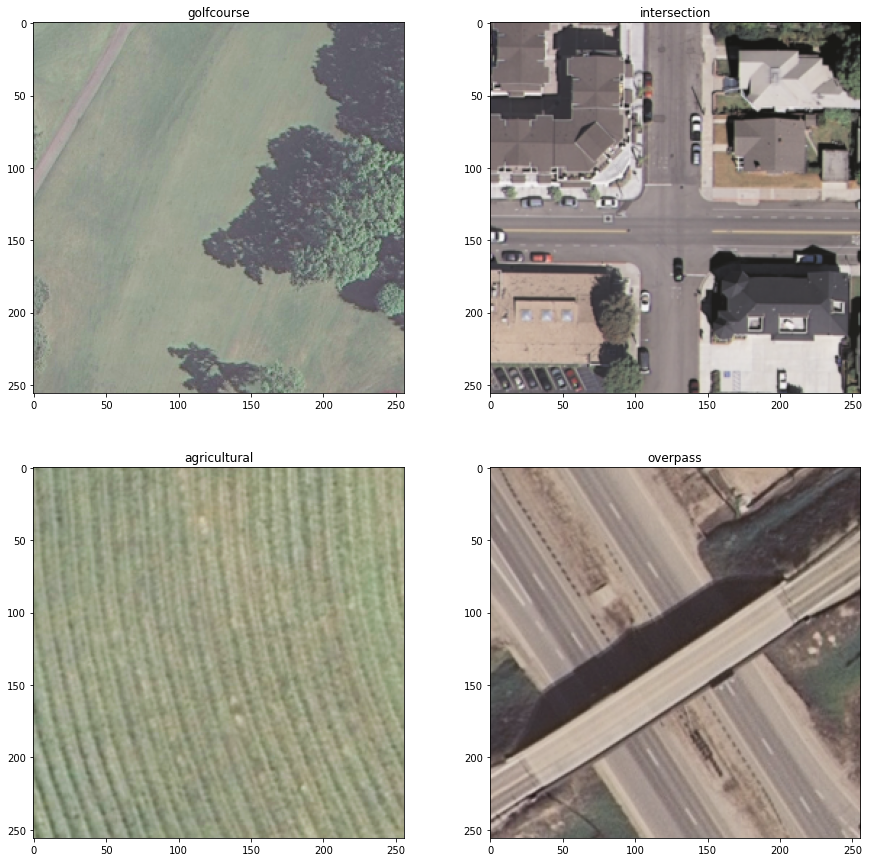

In [12]:
import numpy as np

# Download the pretrained model so that you can
# visualize the results.
MODEL_URL = "https://masterful-public.s3.us-west-1.amazonaws.com/datasets/ucmerced/trained_model.tar.gz"

model = None
with tempfile.TemporaryDirectory() as temp_directory:
  # Download the pretrained model from S3.
  saved_model_path = os.path.join(temp_directory, "saved_model.tar.gz") 
  _ =  urllib.request.urlretrieve(MODEL_URL, saved_model_path, progress_bar_factory("Downloading Model: "))

  # Extract the model weights from the tar file.
  with tarfile.open(saved_model_path) as tar:
    tar.extractall(temp_directory)
  saved_model_path = os.path.join(temp_directory, "saved_model") 

  image1 = tf.io.decode_image(urllib.request.urlopen(urllib.request.Request(os.path.join(DATASET_ROOT, image1_path))).read(), channels=3, dtype=tf.uint8)
  image2 = tf.io.decode_image(urllib.request.urlopen(urllib.request.Request(os.path.join(DATASET_ROOT, image2_path))).read(), channels=3,  dtype=tf.uint8)
  image3 = tf.io.decode_image(urllib.request.urlopen(urllib.request.Request(os.path.join(DATASET_ROOT, image3_path))).read(), channels=3,  dtype=tf.uint8)
  image4 = tf.io.decode_image(urllib.request.urlopen(urllib.request.Request(os.path.join(DATASET_ROOT, image4_path))).read(), channels=3,  dtype=tf.uint8)

  # Load the trained tensorflow saved model.
  model = tf.saved_model.load(saved_model_path)

  # The default inference function for tensorflow saved
  # models is named `serving_default`.
  inference_fn = model.signatures["serving_default"]

    
  # The inference function is a one-arg callable, whose
  # input argument is `image` - the image to predict on,
  # and which returns a dictionary of outputs. The dictionary
  # contains an item whose key is `prediction`, which is the
  # predictions of the model.
  image1_predictions = inference_fn(image=image1)['prediction']
  image2_predictions = inference_fn(image=image2)['prediction']
  image3_predictions = inference_fn(image=image3)['prediction']
  image4_predictions = inference_fn(image=image4)['prediction']

  # Threshold the predictions to determine the class prediction. For multi-class classification,
  # we can take the maximum prediction (argmax)
  image1_predictions = np.argmax(image1_predictions.numpy())
  image2_predictions = np.argmax(image2_predictions.numpy())
  image3_predictions = np.argmax(image3_predictions.numpy())
  image4_predictions = np.argmax(image4_predictions.numpy())
    
  f, axarr = plt.subplots(2, 2, figsize=(15,15))
  _ = axarr[0, 0].imshow(image1)
  _ = axarr[0, 0].title.set_text(label_map[str(image1_predictions)])
  _ = axarr[0, 1].imshow(image2)
  _ = axarr[0, 1].title.set_text(label_map[str(image2_predictions)])
  _ = axarr[1, 0].imshow(image3)
  _ = axarr[1, 0].title.set_text(label_map[str(image3_predictions)])
  _ = axarr[1, 1].imshow(image4)
  _ = axarr[1, 1].title.set_text(label_map[str(image4_predictions)])


As you can see in the above predictions, the model correctly classifies all four images.

## Using the Model for Inference

The [Output Formats](../markdown/guide_cli_model_output_formats.md) guide has more information about how to use the models output by Masterful. You made some predictions above in the [View the Predictions](#view-the-predictions) section, so let's recap the important parts below:

In [15]:
# This image corresponds to the first image (upper left)
# in the `View the Predictions` section above.
IMAGE_URL = "https://masterful-public.s3.us-west-1.amazonaws.com/datasets/ucmerced/images/golfcourse17.png"

# Load the trained model so that you can test running inference.
MODEL_URL = "https://masterful-public.s3.us-west-1.amazonaws.com/datasets/ucmerced/trained_model.tar.gz"

model = None
with tempfile.TemporaryDirectory() as temp_directory:
  # Download the pretrained model from S3.
  saved_model_path = os.path.join(temp_directory, "saved_model.tar.gz") 
  _ =  urllib.request.urlretrieve(MODEL_URL, saved_model_path, progress_bar_factory("Downloading Model: "))

  # Extract the model weights from the tar file.
  with tarfile.open(saved_model_path) as tar:
    tar.extractall(temp_directory)
  saved_model_path = os.path.join(temp_directory, "saved_model") 

  # Load the trained tensorflow saved model.
  model = tf.saved_model.load(saved_model_path)

# Download the image to use for generating a prediction
# and convert it into a tensor.
http_response = requests.get(IMAGE_URL, stream=True)
image = tf.io.decode_image(http_response.raw.read())

image_height = image.shape[0]
image_width = image.shape[1]
print(f"Image Shape: height={image_height} width={image_width}.")

# The default inference function for tensorflow saved
# models is named `serving_default`.
inference_fn = model.signatures["serving_default"]

# The inference function is a one-arg callable, whose
# input argument is `image` - the image to predict on,
# and which returns a dictionary of outputs. The dictionary
# contains an item whose key is `prediction`, which is the
# predictions of the model.
predictions = inference_fn(image=image)['prediction']

# Convert the predictions to NumPY for easier processing.
predictions = predictions.numpy()

# The predictions from a classification model
# have the shape [batch size, number of classes]. 
# The batch size will always be 1 for inference models,
# since they expect only one image for to predict on.
print(f"Predictions shape is {predictions.shape}")

class_prediction = np.argmax(predictions)
print(f"The model predicted class '{label_map[str(class_prediction)]}'.")

Image Shape: height=256 width=256.
Predictions shape is (1, 21)
The model predicted class 'golfcourse'.


## Next Steps

In the above sections, you have learned how to train an image classification model using the Masterful CLI, evaluate the performance of the model, and use the model to make predictions on your production data.

If you want to look at more computer vision tasks, you can try [Detecting Digits](../notebooks/guide_cli_digit_detection.ipynb). If you want to look at another, more involved Object Detection example, see [Detecting Pedestrians in Street Level Imagery](../notebooks/guide_cli_object_detection_pedestrians.ipynb) for more information. Otherwise, feel free to explore [Segmenting Animals](../notebooks/guide_cli_semantic_segmentation.ipynb) for other examples of using the Masterful CLI Trainer to solve challenging computer vision problems.